In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from os import listdir
from matplotlib import image
import matplotlib.pyplot as plt
import numpy as np
import random
from math import floor
from sklearn.preprocessing import StandardScaler
import torch
torch.manual_seed(17)
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.optim import Adam, SGD
from math import floor
from torch.utils.data import Dataset
from __future__ import division
import math
from PIL import Image, ImageOps
try:
    import accimage
except ImportError:
    accimage = None
import numbers
import types
import collections
from math import floor, ceil
import scipy.io
from scipy.ndimage import gaussian_filter
from scipy.io import savemat
from math import sqrt

In [4]:
!unzip -uq "/content/drive/MyDrive/DL HW2 Q2/part_B.zip" -d "/content"
!unzip -uq "/content/drive/MyDrive/DL HW2 Q2/folders.zip" -d "/content"
!unzip -uq "/content/drive/MyDrive/DL HW2 Q2/test_folders.zip" -d "/content"



In [5]:
device =torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
#ground truth train
gr_truth=listdir("/content/part_B/train_data/ground-truth")
#original pic train
pics=listdir("/content/part_B/train_data/images")

In [7]:
gr_truth=[i.split('.')[0] for i in gr_truth]

In [8]:
pic_size=(3, 768, 1024)
#channel first format
P_H=260
P_W=260

H_lst=range(int(pic_size[1]-260))
W_lst=range(int(pic_size[2]-260))


In [9]:
# patches will be saved here
data_train_path="/content/pic_train"
label_train_path="/content/train_label"

#we should read data and coordinations from here
pics_path="/content/part_B/train_data/images"
ground_truth_path="/content/part_B/train_data/ground-truth"


# base of names
names=listdir(pics_path)
names=[i.split('.')[0] for i in names]

H_lst=range(768-260)
W_lst=range(1024-260)

#saving patches and coordinates
j=0
for name in names:
    random.seed(j)
    j=j+1
    ind_H=random.sample(H_lst,9)
    ind_W=random.sample(W_lst,9)

    picture=Image.open(pics_path+'/'+name+'.jpg')
    mat = scipy.io.loadmat(ground_truth_path+'/GT_'+name+'.mat')
    coordinate=np.copy(mat['image_info'][0][0][0][0][0])
    coordinate=coordinate.astype('int32')
    
    for i in range(9):
      left =ind_W[i]
      top = ind_H[i]
      right = ind_W[i]+260
      bottom = ind_H[i]+260
      crop_param=((left, top, right, bottom))
      cropped = picture.crop(crop_param)
      cropped.save(data_train_path+'/'+name+'_'+str(i+1)+'.jpg', "JPEG")

      label=np.zeros(np.shape(coordinate))
      label[:,1]=coordinate[:,1]-ind_H[i]
      label[:,0]=coordinate[:,0]-ind_W[i]

      label=label[label[:,0]>0]
      label=label[label[:,1]>0]

      label=label[label[:,0]<260]
      label=label[label[:,1]<260]
      label=label/4
      label=label.astype('int32')

      label=label[:,[1,0]]

      mdic = {"label": label}

      savemat(label_train_path+'/'+name+'_'+str(i+1)+'.mat', mdic)
     

In [10]:
#https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
#I used their tutorial Here
class Customized_Dataset(Dataset):
  def __init__(self,ID_lst,pic_root,label_root): 
    self.ID_lst=ID_lst
    self.pic_root=pic_root
    self.label_root=label_root

  def __len__(self):
    return len(self.ID_lst)

  def Heat_Map(self,heads_loc):
    heatmap=np.zeros((65,65))
    for i,j in heads_loc:
      heatmap[i][j]=1
    heatmap=gaussian_filter(heatmap,sigma=3)
    heatmap=torch.from_numpy(heatmap)
    return heatmap

  def __getitem__(self,index):
    name = self.ID_lst[index]
    
    transform=transforms.Compose([transforms.ToTensor()])
    

    img=Image.open(self.pic_root+name+'.jpg')

    img=transform(img)
  
    loc_mat=scipy.io.loadmat(self.label_root+name+'.mat')

    loc_mat=loc_mat['label']

    heatmap=self.Heat_Map(loc_mat)

    return img,heatmap

In [11]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.conv1=nn.Conv2d(3,32,11,padding=5)

    self.conv2=nn.Conv2d(32,32,7,padding=3)

    self.maxpool_1=nn.MaxPool2d(2,stride=2)

    self.conv3=nn.Conv2d(32,64,5,padding=2)
    
    self.maxpool_2=nn.MaxPool2d(2,stride=2)

    self.conv4=nn.Conv2d(64,1000,1,padding=0)
    

    self.conv5=nn.Conv2d(1000,400,1,padding=0)
    

    self.conv6=nn.Conv2d(400,1,1,padding=0)
    

  def forward(self,X):
    X=self.conv1(X)
    X=F.relu(X)

    X=self.conv2(X)
    X=F.relu(X)
    X=self.maxpool_1(X)

    X=self.conv3(X)
    X=F.relu(X)
    X=self.maxpool_2(X)

    X=self.conv4(X)
    X=F.relu(X)

    X=self.conv5(X)
    X=F.relu(X)

    X=self.conv6(X)

    X=F.relu(X)
    return X


In [12]:
def Loss_function(output,label):
  m=output.shape[0]
  label=label.reshape(m,1,65,65)
  return 0.5*((output - label) ** 2).sum() / output.data.nelement()



In [13]:
def MAE(output,label):
  m=output.shape[0]
  output=output.reshape(m,65,65)
  output=output.sum(axis=2).sum(axis=1)
  label=label.sum(axis=2).sum(axis=1)

  M_S_E=nn.MSELoss(reduction='sum')
  return M_S_E(output,label)
  

In [14]:
def MSE(output,label):
  m=output.shape[0]
  output=output.reshape(m,65,65)
  output=output.sum(axis=2).sum(axis=1)
  label=label.sum(axis=2).sum(axis=1)

  M_A_E=nn.L1Loss(reduction='sum')
  return M_A_E(output,label)
  

In [15]:
Network=Net()
Network.to(device)
optimizer = torch.optim.SGD(Network.parameters(),lr=0.0005,momentum=0.8)

In [16]:
pic_root='/content/pic_train/'
label_root='/content/train_label/'

ID_lst=listdir('/content/pic_train')
ID_lst=[ID.split('.')[0] for ID in ID_lst]
random.seed(10)
random.shuffle(ID_lst)
L=len(ID_lst)

ID_train=ID_lst[:ceil(0.9*L)]
params_train = {'batch_size': 16,
          'shuffle': True,
          'num_workers': 6}
training_set = Customized_Dataset(ID_train,pic_root,label_root)
training_generator = torch.utils.data.DataLoader(training_set, **params_train)


ID_val=ID_lst[ceil(0.9*L):]
params_val = {'batch_size': 5,
          'shuffle': True,
          'num_workers': 6}
validation_set=Customized_Dataset(ID_val,pic_root,label_root)
val_generator = torch.utils.data.DataLoader(validation_set, **params_val)

n_batch_train=ceil(len(ID_train)/params_train['batch_size'])
n_batch_val=ceil(len(ID_val)/params_val['batch_size'])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [17]:
epochs=10
running_loss=0

train_loss_pe=[]
val_loss_pe=[]

MSE_train_lst=[]
MAE_train_lst=[]

MSE_val_lst=[]
MAE_val_lst=[]


for epoch in range(epochs):
  tr_l_pe=0
  val_l_pe=0
  count=0

  MAE_val_count=0
  MAE_train_count=0

  MSE_val_count=0
  MSE_train_count=0


  for i ,data_train in enumerate(training_generator,0):
    inputs_train,labels_train=data_train[0].to(device),data_train[1].to(device)
    optimizer.zero_grad()
    outputs_train=Network(inputs_train)
    labels_train=labels_train.float()
    loss=Loss_function(outputs_train,labels_train)
    loss.backward()
    optimizer.step()
    print('batch loss:',loss.item())

    running_loss+=loss.item()
    tr_l_pe+=loss.item()
    if i%20==19:
      print('[%d,%5d] loss: %f'%(epoch+1,i+1,running_loss/20))
      running_loss=0
    MAE_train_count+=MAE(outputs_train,labels_train).item()
    MSE_train_count+=MSE(outputs_train,labels_train).item()


  train_loss_pe.append(tr_l_pe/n_batch_train)
  MAE_train_lst.append(MAE_train_count/len(ID_train))
  MSE_train_lst.append(sqrt(MSE_train_count/len(ID_train)))
  print('train loss per epoch: ',tr_l_pe/n_batch_train)

  for i ,data_val in enumerate(val_generator,0):
    inputs_val,labels_val=data_val[0].to(device),data_val[1].to(device)
    outputs_val=Network(inputs_val)
    labels_val=labels_val.float()
    loss_val=Loss_function(outputs_val,labels_val)
    val_l_pe+=loss_val.item()
    MAE_val_count+=MAE(outputs_val,labels_val).item()
    MSE_val_count+=MSE(outputs_val,labels_val).item()

  val_loss_pe.append(val_l_pe/n_batch_val)
  MAE_val_lst.append(MAE_val_count/len(ID_val))
  MSE_val_lst.append(sqrt(MSE_val_count/len(ID_val)))
  print('val loss per epoch: ',val_l_pe/n_batch_val)


  print('epoch',epoch+1)
print('finied training')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


batch loss: 0.0011019343510270119
batch loss: 0.0010912819998338819
batch loss: 0.001081677502952516
batch loss: 0.0010821727337315679
batch loss: 0.0010468974942341447
batch loss: 0.0010868343524634838
batch loss: 0.001054697553627193
batch loss: 0.0010250527411699295
batch loss: 0.0010426797671243548
batch loss: 0.001033357228152454
batch loss: 0.001006771926768124
batch loss: 0.0009839286794885993
batch loss: 0.0009664830286055803
batch loss: 0.0010032913414761424
batch loss: 0.000982671626843512
batch loss: 0.0009876629337668419
batch loss: 0.0009521098691038787
batch loss: 0.0009293562616221607
batch loss: 0.0009644428500905633
batch loss: 0.0009536567376926541
[1,   20] loss: 0.001019
batch loss: 0.0009056332637555897
batch loss: 0.000896685232874006
batch loss: 0.0009285457781516016
batch loss: 0.0009000484133139253
batch loss: 0.0009119727183133364
batch loss: 0.0008687511435709894
batch loss: 0.0008888414013199508
batch loss: 0.0008605815237388015
batch loss: 0.000860332103911

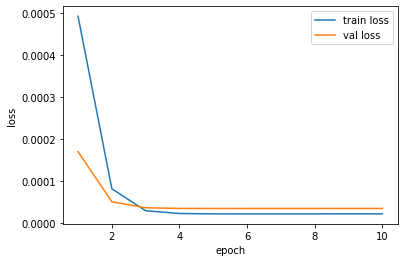

In [18]:

plt.figure
x=list(range(1,epochs+1))
plt.plot(x,train_loss_pe)
plt.plot(x,val_loss_pe)

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train loss','val loss'])

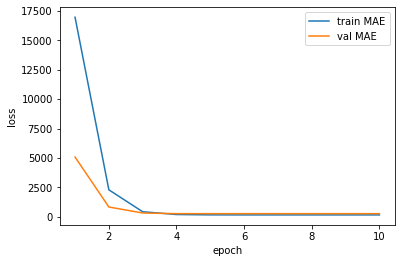

In [19]:

plt.figure
x=list(range(1,epochs+1))
plt.plot(x,MAE_train_lst)
plt.plot(x,MAE_val_lst)

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train MAE','val MAE'])

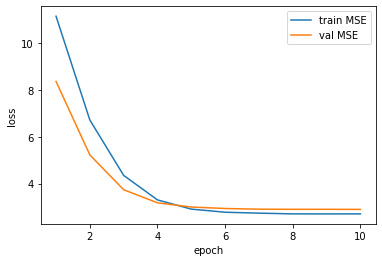

In [20]:

plt.figure
x=list(range(1,epochs+1))
plt.plot(x,MSE_train_lst)
plt.plot(x,MSE_val_lst)

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train MSE','val MSE'])

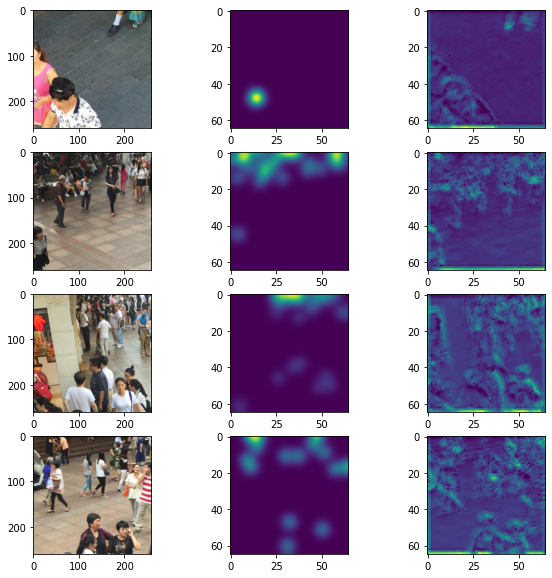

In [21]:
plt.figure(figsize=(10,10))
for k in range(4):
  mm=labels_val[k+1].cpu()
  mm=mm.detach().numpy()
  plt.subplot(4,3,3*k+2)
  plt.imshow(mm)
for k in range(4):
  mm=outputs_val[k+1].cpu()
  mm=mm.detach().numpy()
  mm=mm.reshape(65,65)
  plt.subplot(4,3,3*k+3)
  plt.imshow(mm)
for k in range(4):
  mm=inputs_val[k+1].cpu()
  mm=mm.detach().numpy()
  plt.subplot(4,3,3*k+1)
  plt.imshow(mm.transpose(1,2,0))

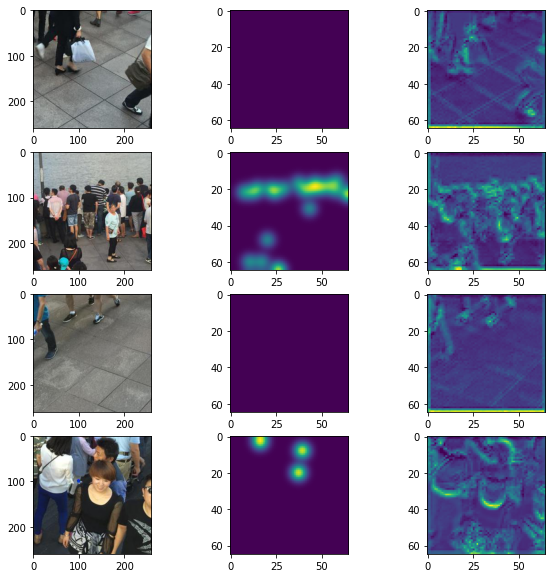

In [22]:
plt.figure(figsize=(10,10))
for k in range(4):
  mm=labels_train[k*1].cpu()
  mm=mm.detach().numpy()
  plt.subplot(4,3,3*k+2)
  plt.imshow(mm)
for k in range(4):
  mm=outputs_train[k*1].cpu()
  mm=mm.detach().numpy()
  mm=mm.reshape(65,65)
  plt.subplot(4,3,3*k+3)
  plt.imshow(mm)
for k in range(4):
  mm=inputs_train[k*1].cpu()
  mm=mm.detach().numpy()
  plt.subplot(4,3,3*k+1)
  plt.imshow(mm.transpose(1,2,0))

loading test

In [23]:
!unzip -uq "/content/drive/MyDrive/DL HW2 Q2/test_folders.zip" -d "/content"

# patches will be saved here
data_test_path="/content/pic_test"
label_test_path="/content/test_label"

#we should read data and coordinations from here
test_pics_path="/content/part_B/test_data/images"
test_ground_truth_path="/content/part_B/test_data/ground-truth"


# base of names
names_test=listdir(test_pics_path)
names_test=[i.split('.')[0] for i in names_test]

H_lst=range(768-260)
W_lst=range(1024-260)

#saving patches and their coordinates
j=0
for name in names_test:
    random.seed(j)
    j=j+1
    ind_H=random.sample(H_lst,9)
    ind_W=random.sample(W_lst,9)

    picture=Image.open(test_pics_path+'/'+name+'.jpg')
    mat = scipy.io.loadmat(test_ground_truth_path+'/GT_'+name+'.mat')
    coordinate=np.copy(mat['image_info'][0][0][0][0][0])
    coordinate=coordinate.astype('int32')
    
    for i in range(9):
      left =ind_W[i]
      top = ind_H[i]
      right = ind_W[i]+260
      bottom = ind_H[i]+260
      crop_param=((left, top, right, bottom))
      cropped = picture.crop(crop_param)
      cropped.save(data_test_path+'/'+name+'_'+str(i+1)+'.jpg', "JPEG")

      label=np.zeros(np.shape(coordinate))
      label[:,1]=coordinate[:,1]-ind_H[i]
      label[:,0]=coordinate[:,0]-ind_W[i]

      label=label[label[:,0]>0]
      label=label[label[:,1]>0]

      label=label[label[:,0]<260]
      label=label[label[:,1]<260]
      label=label/4
      label=label.astype('int32')

      label=label[:,[1,0]]

      mdic = {"label": label}

      savemat(label_test_path+'/'+name+'_'+str(i+1)+'.mat', mdic)


     

In [24]:
pic_root_test='/content/pic_test/'
label_root_test='/content/test_label/'

ID_test=listdir('/content/pic_test')
ID_test=[ID.split('.')[0] for ID in ID_test]
random.seed(10)
random.shuffle(ID_test)

params_test = {'batch_size': 5,
          'shuffle': True,
          'num_workers': 6}
test_set = Customized_Dataset(ID_test,pic_root_test,label_root_test)
test_generator = torch.utils.data.DataLoader(test_set, **params_test)

n_batch_test=ceil(len(ID_test)/params_test['batch_size'])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [25]:
MAE_test_count=0
MSE_test_count=0
for i ,data_test in enumerate(test_generator,0):
    inputs_test,labels_test=data_test[0].to(device),data_test[1].to(device)
    outputs_test=Network(inputs_test)
    labels_test=labels_test.float()
    MAE_test_count+=MAE(outputs_test,labels_test).item()
    MSE_test_count+=MSE(outputs_test,labels_test).item()

MAE_test=MAE_test_count/len(ID_test)
MSE_test=sqrt(MSE_test_count/len(ID_test))

print('test MAE is :',MAE_test)
print('test MSE is :',MSE_test)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


test MAE is : 156.35534210848908
test MSE is : 2.6534193245727407
